<a href="https://colab.research.google.com/github/dsirtioglu/python/blob/dsirtioglu-RR/RR_NL_Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import copy

import matplotlib
from matplotlib import pyplot as plt


Production data sourced from CBS Open Data Stat Line (https://opendata.cbs.nl/statline/portal.html?_la=en&_catalog=CBS&tableId=84575ENG&_theme=1029)

In [45]:
url_nl_production = 'https://raw.githubusercontent.com/dsirtioglu/python/main/NL%20Energy%20Production_all.csv'

nl_production = pd.read_csv(url_nl_production, sep = ';')
nl_production = nl_production.set_index('ID')
nl_production.tail(20)

,Periods,GrossProduction_1,OwnConsumptionForElectrProduction_2,NetProductionTotal_3,NuclearEnergy_4,FuelsTotal_5,Coal_6,OilProducts_7,NaturalGas_8,Biomass_9,OtherFuelsNonRenewable_10,HydroPower_11,WindEnergyTotal_12,WindEnergyOnShore_13,WindEnergyOffShore_14,SolarPhotovoltaic_15,OtherSources_16,ImportsTotal_17,Belgium_18,Denmark_19,Germany_20,UnitedKingdom_21,Norway_22,ExportsTotal_23,Belgium_24,Denmark_25,Germany_26,UnitedKingdom_27,Norway_28,DistributionLosses_29,NetConsumptionCalculated_30
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
793,2019KW04,32986,976,32010,1062,26763,5889,416,18307,1756,395,21,3527,2452,1075.0,523,113,4685,766,461.0,2972,68.0,417.0,5354,1821,550.0,944,1510.0,530.0,1343,29998
794,2019JJ00,121062,3490,117572,3700,96460,19266,1385,69172,5060,1577,74,11508,7935,3573.0,5336,493,20403,4528,619.0,12238,385.0,2634.0,19548,6991,671.0,4398,6148.0,1340.0,5059,113368
795,2020MM01,11534,305,11228,361,9186,928,148,7467,504,140,11,1515,1098,417.0,116,40,1746,57,463.0,921,47.0,260.0,2002,987,2.0,586,422.0,6.0,473,10500
796,2020MM02,10304,280,10023,330,7543,843,146,5848,578,128,2,1899,1477,423.0,210,39,1669,205,372.0,765,46.0,282.0,1508,500,46.0,478,476.0,8.0,424,9761
797,2020MM03,9959,290,9669,360,7192,923,140,5314,699,116,6,1451,1081,370.0,619,41,2029,341,352.0,843,14.0,479.0,1764,466,49.0,655,574.0,20.0,436,9497
798,2020KW01,31796,875,30920,1050,23922,2694,433,18628,1782,384,19,4865,3656,1209.0,944,120,5444,602,1186.0,2528,107.0,1021.0,5274,1953,96.0,1720,1471.0,33.0,1332,29759
799,2020MM04,8289,262,8027,347,5785,473,105,4516,548,142,7,817,597,221.0,1032,40,2029,589,301.0,640,42.0,457.0,1508,255,78.0,663,490.0,22.0,394,8154
800,2020MM05,9476,275,9201,311,6759,502,78,5371,649,158,4,790,581,208.0,1299,38,1899,843,195.0,398,56.0,407.0,2244,264,159.0,1345,450.0,26.0,395,8461
801,2020MM06,9139,245,8893,156,6788,390,96,5654,509,140,2,764,513,251.0,1156,26,1353,330,43.0,660,119.0,201.0,1386,361,229.0,535,254.0,8.0,389,8472


In [61]:
nl_production_monthly = copy.copy(nl_production[nl_production['Periods'].str.contains('MM')])

nl_production_monthly.insert(loc = 0,
                            column = 'Date',
                            value = nl_production_monthly.Periods.str[:4] + nl_production_monthly.Periods.str[-2:])

nl_production_monthly['Date'] = pd.to_datetime(nl_production_monthly['Date'], format = "%Y%m")

nl_production_monthly.tail(20)

,Date,Periods,GrossProduction_1,OwnConsumptionForElectrProduction_2,NetProductionTotal_3,NuclearEnergy_4,FuelsTotal_5,Coal_6,OilProducts_7,NaturalGas_8,Biomass_9,OtherFuelsNonRenewable_10,HydroPower_11,WindEnergyTotal_12,WindEnergyOnShore_13,WindEnergyOffShore_14,SolarPhotovoltaic_15,OtherSources_16,ImportsTotal_17,Belgium_18,Denmark_19,Germany_20,UnitedKingdom_21,Norway_22,ExportsTotal_23,Belgium_24,Denmark_25,Germany_26,UnitedKingdom_27,Norway_28,DistributionLosses_29,NetConsumptionCalculated_30
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
784,2019-06-01,2019MM06,8251,242,8008,32,6529,1047,79,4908,366,129,6,583,414,169.0,849,10,2035,701,0.0,888,46.0,400.0,1077,122,0.0,487,448.0,20.0,392,8576
786,2019-07-01,2019MM07,9392,271,9121,309,7413,1135,143,5616,387,131,1,549,341,207.0,812,38,1763,735,3.0,618,40.0,367.0,1377,142,2.0,653,512.0,68.0,410,9097
787,2019-08-01,2019MM08,9157,250,8907,318,7049,636,121,5745,417,129,1,761,502,258.0,740,38,1843,1117,8.0,408,71.0,239.0,1424,31,15.0,833,391.0,153.0,388,8939
788,2019-09-01,2019MM09,9231,257,8974,337,7189,544,142,6155,249,98,1,925,612,313.0,486,38,1636,641,146.0,442,72.0,335.0,1411,108,104.0,830,315.0,53.0,399,8801
790,2019-10-01,2019MM10,10910,314,10596,354,8823,1631,152,6530,379,131,5,1111,753,358.0,267,36,1254,283,102.0,706,37.0,126.0,1679,346,257.0,532,398.0,146.0,434,9737
791,2019-11-01,2019MM11,11244,356,10888,348,9410,2263,129,6225,666,127,8,937,632,306.0,147,38,1454,97,91.0,1104,7.0,154.0,1963,791,175.0,204,574.0,218.0,445,9933
792,2019-12-01,2019MM12,10832,306,10526,360,8531,1995,136,5553,710,137,8,1478,1068,411.0,109,39,1978,386,268.0,1163,23.0,136.0,1712,684,118.0,207,538.0,165.0,464,10327
795,2020-01-01,2020MM01,11534,305,11228,361,9186,928,148,7467,504,140,11,1515,1098,417.0,116,40,1746,57,463.0,921,47.0,260.0,2002,987,2.0,586,422.0,6.0,473,10500
796,2020-02-01,2020MM02,10304,280,10023,330,7543,843,146,5848,578,128,2,1899,1477,423.0,210,39,1669,205,372.0,765,46.0,282.0,1508,500,46.0,478,476.0,8.0,424,9761


In [60]:
nl_production_monthly.dtypes

Date                                   datetime64[ns]
Periods                                        object
GrossProduction_1                              object
OwnConsumptionForElectrProduction_2            object
NetProductionTotal_3                           object
NuclearEnergy_4                                object
FuelsTotal_5                                   object
Coal_6                                         object
OilProducts_7                                  object
NaturalGas_8                                   object
Biomass_9                                      object
OtherFuelsNonRenewable_10                      object
HydroPower_11                                  object
WindEnergyTotal_12                             object
WindEnergyOnShore_13                           object
WindEnergyOffShore_14                         float64
SolarPhotovoltaic_15                           object
OtherSources_16                                object
ImportsTotal_17             

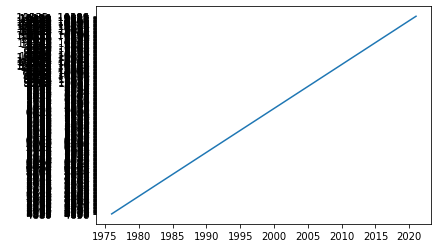

In [84]:
x = nl_production_monthly.Date
y = nl_production_monthly.NetConsumptionCalculated_30

plt.plot(x, y)

In [63]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []
    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)


#plot_dataset(nl_production_monthly, title='Energy Production Million kWh')

In [73]:
import plotly.graph_objs as go
from plotly.offline import iplot

fig = dict(data=nl_production_monthly,
               value = go.Scatter (
                   x = nl_production_monthly.Date,
                   y = nl_production_monthly.NetProductionTotal_3,
                   mode = "lines",
                   name = "values",
                   marker = dict(),
                   text = nl_energy_production.Date,
                   line = dict(color = "rgba(0,0,0,0.3)"),
                ) ,
        layout = dict(
        title="title",
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),     
                )
    )
               
iplot(fig)


ValueError: ignored